# Sentiment analysis: *Amazon fine food review* -  1st part

### Presentation

* The project is based on the Amazon food review from customers dataset
* The original Kaggle competition was to predict whether a review was positive or negative
* In this project, we will add the **neural** level
* You will try to **predict the 3 classes** given by the user according to their **review**
* The dataset contains more than 500K reviews

### Download the data

https://www.kaggle.com/snap/amazon-fine-food-reviews/download

(254MB)

In [ ]:
import re
from pathlib import Path

import gensim
import gensim.downloader as gensim_api
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import seaborn as sns
import wordcloud
from sklearn import (
    decomposition,
    ensemble,
    feature_extraction,
    linear_model,
    metrics,
    model_selection,
    naive_bayes,
    pipeline,
    neighbors
)
from sklearn.feature_extraction.text import CountVectorizer
from tqdm.notebook import tqdm
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
sns.set_style("darkgrid")
sns.set_context("notebook")

tqdm.pandas()

%config InlineBackend.figure_format="retina"  # For high DPI display

1VoxTKX68eEq1fUmvGlUQ0CIAdszjbTuR

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
DATA = Path("drive/My Drive/data")

assert DATA.is_dir()

IMG = Path("drive/My Drive/img")

assert IMG.is_dir()

## Exploration

### Read Data

In [ ]:
raw_df = pd.read_csv(DATA / "Reviews.csv")
raw_df.head()

raw_dim = raw_df.shape[0]
df = raw_df[~raw_df.duplicated(["Text", "Summary"])].copy()
dim = df.shape[0]

print(f"{dim / raw_dim:.2%}, raw_dim: {raw_dim:,}, dim: {dim:,}")

df = raw_df[~raw_df.duplicated(["Text", "Summary", "Score"])]
df[df.duplicated(["Text", "Summary"], keep=False)].shape[0]

69.48%, raw_dim: 568,454, dim: 394,970


72

* Contains some product, user, and review information

* Data used here:

    * Text: Complete product review by the customer
    * Summary: Summary proposed by the customer
    * Score: The product rating provided by the customer

### Distribution of the variable ***Score***

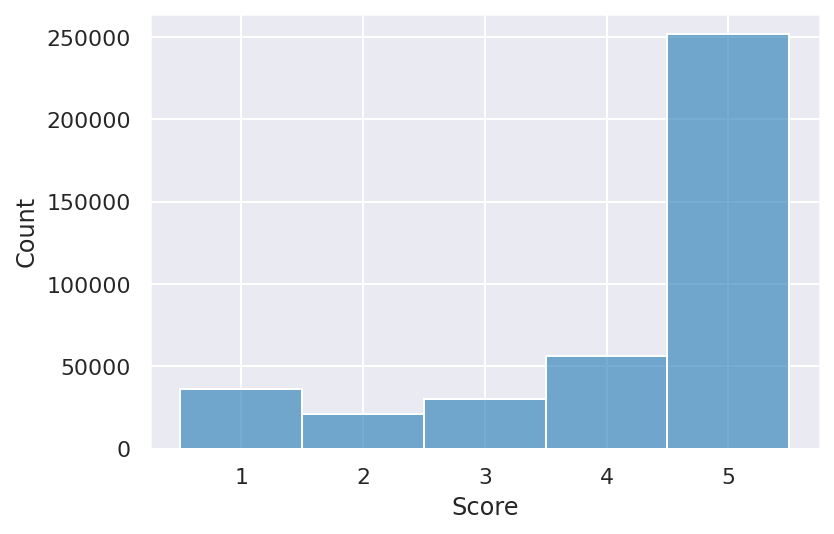

In [ ]:
sns.histplot(df, x="Score", alpha=0.6, discrete=True)
plt.show()

* Most of the customer reviews are positive

### Analysis of binary and 3-classes versions

* Convert the 5-grade rating to a 3-grade sentiment as a target variable
* Positive ratings will be classified as +1, neutral 0, and negative -1
* The value of 3 in the rating will be used as threshold

In [ ]:
def convert_rating(rating, threshold=3):
    if rating > threshold:
        return 1
    if rating < threshold:
        return -1
    return 0

In [ ]:
df["sentiment"] = df.Score.map(convert_rating)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


### Words distribution

Let's observe the most frequent words for positive and negative reviews through **word clouds**

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# Create stopword list

diff_stopwords = set(wordcloud.STOPWORDS) ^ set(
    nltk.corpus.stopwords.words("english")
)
print(len(diff_stopwords))

stopwords = set(wordcloud.STOPWORDS) | set(
    nltk.corpus.stopwords.words("english")
)
stopwords.update(["br", "href"])

print(len(stopwords))

81
227


In [ ]:
%%script skip
positive_df = df[df.sentiment == 1]

pos_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(positive_df.Summary.dropna()))

plt.imshow(pos_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "pos_wordcloud.png")
plt.show()

Couldn't find program: 'skip'


In [ ]:
%%script skip
negative_df = df[df.sentiment == -1]

neg_wordcloud = WordCloud(
    stopwords=stopwords,
    background_color="white",
).generate(" ".join(negative_df.Summary.dropna()))

plt.imshow(neg_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(IMG / "neg_wordcloud.png")
plt.show()

Couldn't find program: 'skip'


* Positive sentiment words, e.g., *love, best, delicious*

* Negative sentiment words, e.g., *disappointed, bad, yuck*

* The word ***good*** appears in the negative sentiment word cloud, despite being a positive word 

    * Probably because it was used in a negative context: ***not good*** 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


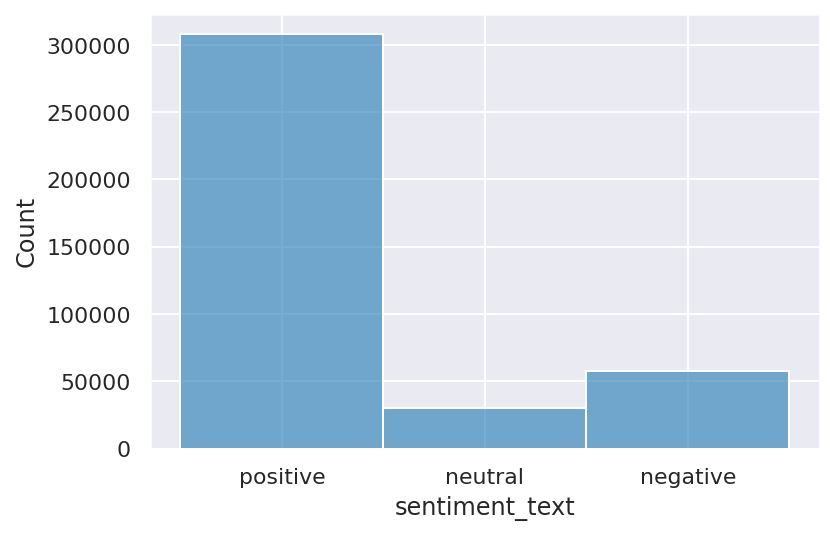

In [ ]:
df["sentiment_text"] = (
    df.sentiment.replace({-1: "negative", 0: "neutral", 1: "positive"})
    .astype("category")  # To set the x-axis order in sns.histplot
    .cat.reorder_categories(["positive", "neutral", "negative"])
)

sns.histplot(
    df,
    x="sentiment_text",
    alpha=0.6,
    discrete=True,
)
plt.show()

## Create the train and test sets

It is **crucial** to keep the **test set** for the very last check when the model has been built.

In [ ]:
train_df, test_df = model_selection.train_test_split(
    df, test_size=0.2, random_state=1
)

In [ ]:
train_df.shape

(316004, 12)

## Baseline Model with `Summary`

In [ ]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

Split the data into a train (80%) and validation sets (20%)

In [ ]:
text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Summary, cln_df.sentiment, test_size=0.2, random_state=1
)

In [ ]:
text_train

371400                                                 YUM!
171843    Amazing food for cats with sensitive digestive...
442351                                          gummy yummy
7185                                 Spicy and Flavorful...
134458                                    My Dog Loves Them
                                ...                        
247418                                         great cereal
446421                     A yogi tea with a hint of ginger
347055                    Great healthy and delicious treat
268229                                 nature's path cereal
212960                           Via 40th Anniversary Blend
Name: Summary, Length: 252801, dtype: object

### Baseline model with counting based vectorization

In [ ]:
vectorizer = CountVectorizer()

x_train = vectorizer.fit_transform(text_train)
x_valid = vectorizer.transform(text_valid)

In [ ]:
model = naive_bayes.MultinomialNB()

# model = linear_model.SGDClassifier(loss="log")

model.fit(x_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(x_valid)

### Evaluation

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.60      0.67      0.63      8224
           0       0.20      0.46      0.28      2175
           1       0.95      0.89      0.92     52802

    accuracy                           0.84     63201
   macro avg       0.58      0.67      0.61     63201
weighted avg       0.88      0.84      0.86     63201



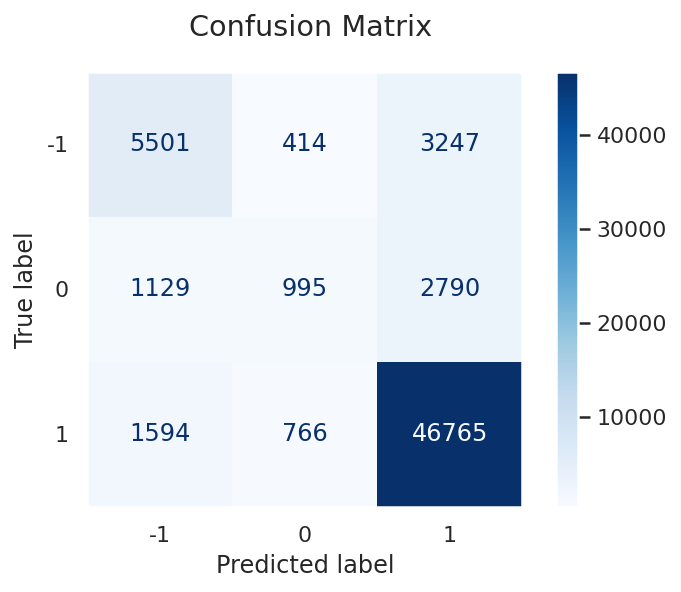

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, x_valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

## Baseline Model with `Text` Reviews

In [ ]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

Split the data into train (80%) and validation sets (20%)

In [ ]:
text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)

In [ ]:
text_train

139130    PROS<br />-great to start as finger foods (eas...
171843    My ten month old cat was switched from dry kit...
520201    I purchased this tea looking for a ice tea tha...
7185      I've given these to friends that don't eat spi...
63962     Buy this product for my grandparents because t...
                                ...                        
67483     If you have a need for an above the fold hot s...
446421    The Yogi brand "Ginger Tea" has a whole lot of...
338975    If you have moths/grubs infesting your flour a...
257297    What I enjoy most about this body wash is:<br ...
540702    I have to travel to Las Vegas to a Smart & Fin...
Name: Text, Length: 252803, dtype: object

In [ ]:
vectorizer = CountVectorizer()  # token_pattern=r"\b\w+\b"

x_train = vectorizer.fit_transform(text_train)
x_valid = vectorizer.transform(text_valid)

In [ ]:
model = naive_bayes.MultinomialNB()

# model = linear_model.SGDClassifier(loss="log")  # loss="log"

model.fit(x_train, y_train)

MultinomialNB()

In [ ]:
y_pred = model.predict(x_valid)

### Evaluation

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.65      0.63      0.64      9471
           0       0.26      0.33      0.29      3740
           1       0.92      0.91      0.91     49990

    accuracy                           0.83     63201
   macro avg       0.61      0.62      0.61     63201
weighted avg       0.84      0.83      0.83     63201



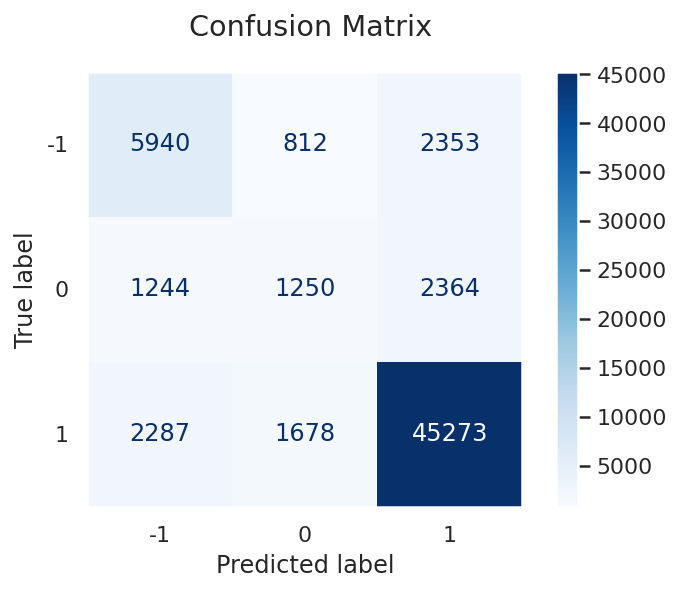

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, x_valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

## Word Embeddings-based Model

**!! Attention !!** the pre-trained Word2Vec model used on Gensim is large (1.6G), so I used the much smaller proposed Glove model instead (128M).

In [ ]:
# List of model available on Gensim

for k in gensim_api.info()["models"]:
    print(k)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


In [ ]:
WV = gensim_api.load("glove-wiki-gigaword-100")

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

In [ ]:
def vectorize_sentence_bow(words, wv=WV): # bag of words
    embeddings = []
    for word in words:
        try:
            embeddings.append(wv[word])
        except KeyError:
            pass
    return np.array(embeddings).mean(axis=0)

### Tokenisation and embeddings (!! slow !!)

In [ ]:
tokenizer_re = re.compile(r"(?u)\b\w\w+\b")  # r"\w+" r"[\w-]+"

cln_df["words"] = cln_df.Text.str.findall(tokenizer_re)
cln_df["embeddings"] = cln_df.words.progress_map(vectorize_sentence_bow)
cln_df.dropna(inplace=True)

  0%|          | 0/316004 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Split the data into a train (80%) and test sets (20%)

In [ ]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1,
)

In [ ]:
model = linear_model.SGDClassifier()  # loss="log"

model.fit(x_train, y_train)

SGDClassifier()

In [ ]:
y_pred = model.predict(x_valid)

### Evaluation

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.12      0.69      0.20      1562
           0       0.00      0.00      0.00         0
           1       0.99      0.79      0.88     61365

    accuracy                           0.79     62927
   macro avg       0.37      0.49      0.36     62927
weighted avg       0.97      0.79      0.86     62927



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


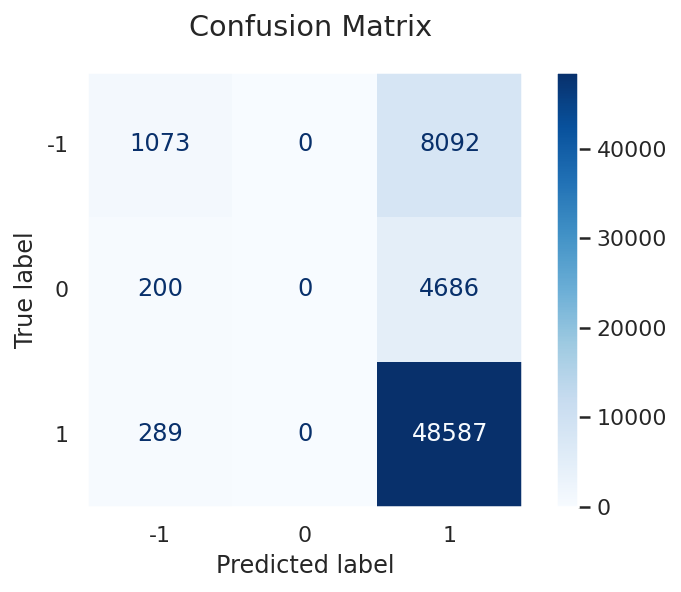

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, x_valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

Very bad results.

# Using (1, 2)-grams on 'Text' Reviews

In [ ]:
text_train, text_valid, y_train, y_valid = model_selection.train_test_split(
    cln_df.Text, cln_df.sentiment, test_size=0.2, random_state=1
)

In [ ]:
vectorizer2 = CountVectorizer(ngram_range = (1, 2))

x_train = vectorizer2.fit_transform(text_train)
x_valid = vectorizer2.transform(text_valid)

In [ ]:
%%script skip
from sklearn.linear_model import Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import ensemble
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

models = [
    Perceptron(tol=1e-3, random_state=0),
    LinearSVC(random_state=0, tol=1e-5),
    ensemble.RandomForestClassifier(n_estimators=10),
    GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0),
    MLPClassifier(random_state=1, max_iter=500,hidden_layer_sizes = [200,100,50,25]),
]

for model in models:
    print(model)
    model.fit(x_train.toarray(), y_train)  # training
    y_pred = model.predict(x_valid)
    print(metrics.classification_report(y_pred, y_valid))
    #pred = {
    #data_set: model.predict(xps[data_set]) 
    #for data_set in ALL_SETS
    #}

Couldn't find program: 'skip'


In [ ]:
model = naive_bayes.MultinomialNB()

model.fit(x_train, y_train)

y_pred = model.predict(x_valid)

              precision    recall  f1-score   support

          -1       0.44      0.82      0.58      4976
           0       0.01      0.65      0.02        65
           1       0.99      0.84      0.91     57886

    accuracy                           0.84     62927
   macro avg       0.48      0.77      0.50     62927
weighted avg       0.95      0.84      0.88     62927



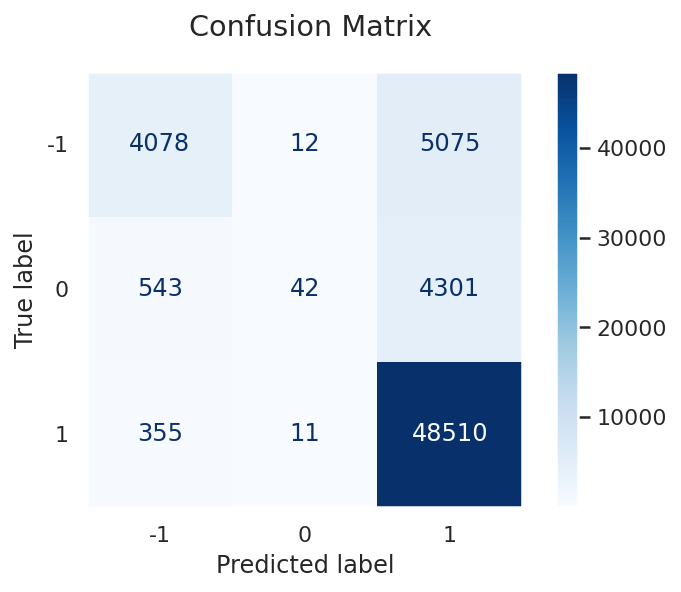

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, x_valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

The results are not that bad (excluding the class 0).

# Using (1, 3)-grams on 'Summary'

In [ ]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

In [ ]:
vectorizer = CountVectorizer(ngram_range = (1,3))
v_data = vectorizer.fit_transform(cln_df["Summary"])

In [ ]:
vectorizer.get_feature_names()[:20]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['00',
 '00 49',
 '00 49 bag',
 '00 at',
 '00 at any',
 '00 at costco',
 '00 at linens',
 '00 box',
 '00 box it',
 '00 chocolate',
 '00 chocolate bar',
 '00 coffee',
 '00 coffee break',
 '00 coffee maker',
 '00 dollar',
 '00 dollar increase',
 '00 dollars',
 '00 dollars for',
 '00 ever',
 '00 ever spent']

In [ ]:
train, valid, y_train, y_valid = model_selection.train_test_split(v_data, cln_df["sentiment"], test_size=0.2, random_state = 42)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

tr = preprocessing.normalize(train) # It normalizes using the unit norm
va = preprocessing.normalize(valid)

In [ ]:
model = naive_bayes.MultinomialNB()

model.fit(tr, y_train)

True

In [ ]:
y_pred = model.predict(va)
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.25      0.88      0.39      2583
           0       0.02      0.81      0.03        98
           1       1.00      0.81      0.90     60520

    accuracy                           0.81     63201
   macro avg       0.42      0.83      0.44     63201
weighted avg       0.97      0.81      0.87     63201



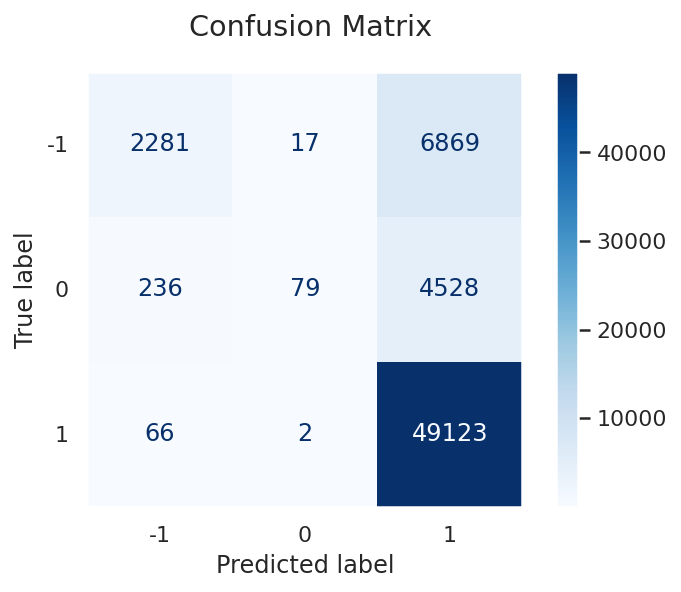

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, va, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

Results are not better.

# TFiDF

In [ ]:
## TFidf Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range = (1,2))
v_data = vectorizer.fit_transform(cln_df["Summary"])

In [ ]:
train, valid, y_train, y_valid = model_selection.train_test_split(v_data, cln_df["sentiment"], test_size=0.2, random_state = 42)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer

tr = preprocessing.normalize(train)
va = preprocessing.normalize(valid)

In [ ]:
model = naive_bayes.MultinomialNB()

model.fit(tr, y_train)

True

In [ ]:
y_pred = model.predict(va)
y_pred

array([ 1,  1,  1, ...,  1, -1,  1])

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.36      0.85      0.51      3880
           0       0.04      0.71      0.08       277
           1       1.00      0.83      0.91     59044

    accuracy                           0.83     63201
   macro avg       0.47      0.80      0.50     63201
weighted avg       0.95      0.83      0.88     63201



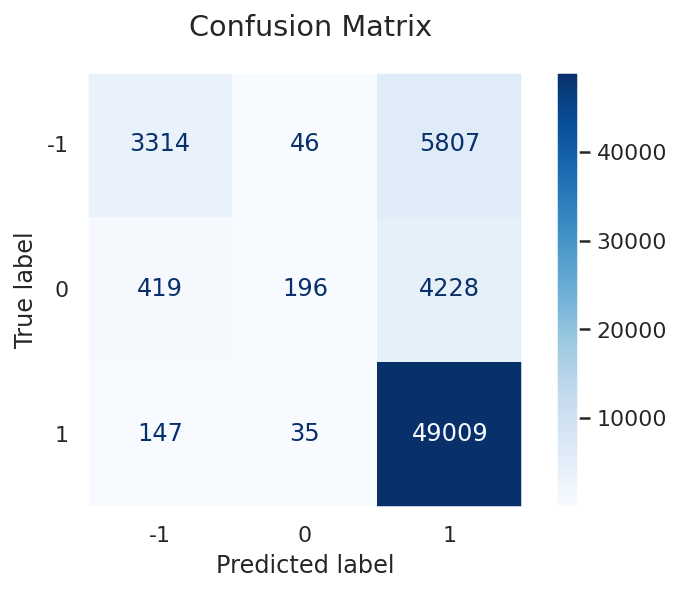

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, va, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

# Doc2Vec

In [ ]:
df_d2v = df[["Summary", "sentiment"]].copy()
df_d2v.dropna(inplace=True)
df_d2v.drop_duplicates(subset=['Summary'])
df_d2v

,Summary,sentiment
0,Good Quality Dog Food,1
1,Not as Advertised,-1
2,"""Delight"" says it all",1
3,Cough Medicine,-1
4,Great taffy,1
...,...,...
568449,Will not do without,1
568450,disappointed,-1
568451,Perfect for our maltipoo,1
568452,Favorite Training and reward treat,1


In [ ]:
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec

def build_voc(df):
    w = re.compile("\w+",re.I) # We use the regex to get all the words
    labeled_sentences = []
    for index, datapoint in df.iterrows():
        tokenized_words = re.findall(w, datapoint["Summary"].lower()) # We retrieve all the words following the rule
        labeled_sentences.append(LabeledSentence(words=tokenized_words, tags=['SENT_%s' %index])) # Token associated with an index
    return labeled_sentences

sen = build_voc(df_d2v)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `LabeledSentence` (Class will be removed in 4.0.0, use TaggedDocument instead).
  if __name__ == '__main__':


In [ ]:
m = Doc2Vec(alpha=0.025, min_alpha=0.025)
m.build_vocab(sen) # We convert to vectors
print(m)

Doc2Vec(dm/m,d100,n5,w5,mc5,s0.001,t3)


In [ ]:
def vectorize_comments(df,d2v_model):
    y = []
    comments = []
    for i in range(0,df.shape[0]):
        comments.append(d2v_model.docvecs[i])
    df['vectorized_comments'] = comments
    return df

df_d2v = vectorize_comments(df_d2v,m) # We add this column to the dataset

In [ ]:
df_d2v

,Summary,sentiment,vectorized_comments
0,Good Quality Dog Food,1,"[0.0005264303, -0.00064912176, -0.0029666533, ..."
1,Not as Advertised,-1,"[0.0014698197, 0.004492081, -0.0023419794, -0...."
2,"""Delight"" says it all",1,"[0.0044980505, 0.0019391353, 0.0047967853, -0...."
3,Cough Medicine,-1,"[-0.0028111853, -0.0011782607, -0.0028472203, ..."
4,Great taffy,1,"[-0.0009929007, 0.0025997558, -0.0039333045, -..."
...,...,...,...
568449,Will not do without,1,"[0.0014655502, -0.00034005157, 0.0040691523, 0..."
568450,disappointed,-1,"[-0.0021244702, 0.0028356174, 0.0044278908, 0...."
568451,Perfect for our maltipoo,1,"[0.00071842264, -0.0033342927, 0.0026037823, 0..."
568452,Favorite Training and reward treat,1,"[-0.0011373778, -0.0025053627, -0.00051173894,..."


In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from imblearn.ensemble import BalancedRandomForestClassifier

model = BalancedRandomForestClassifier(n_estimators = 100, max_depth = 14)

train, valid, y_train, y_valid = model_selection.train_test_split(df_d2v["vectorized_comments"].T.tolist(), df_d2v["sentiment"], test_size=0.2, random_state = 42)

model.fit(train, y_train)

BalancedRandomForestClassifier(n_estimators=100,max_depth=14)

In [ ]:
y_pred = model.predict(valid)
y_pred

array([ 0, -1, -1, ...,  1,  0,  1])

In [ ]:
metrics.confusion_matrix(y_pred, y_valid)
print(metrics.classification_report(y_pred, y_valid))

              precision    recall  f1-score   support

          -1       0.36      0.15      0.21     27823
           0       0.34      0.08      0.12     26627
           1       0.31      0.78      0.44     24551

    accuracy                           0.32     79001
   macro avg       0.34      0.33      0.26     79001
weighted avg       0.34      0.32      0.25     79001



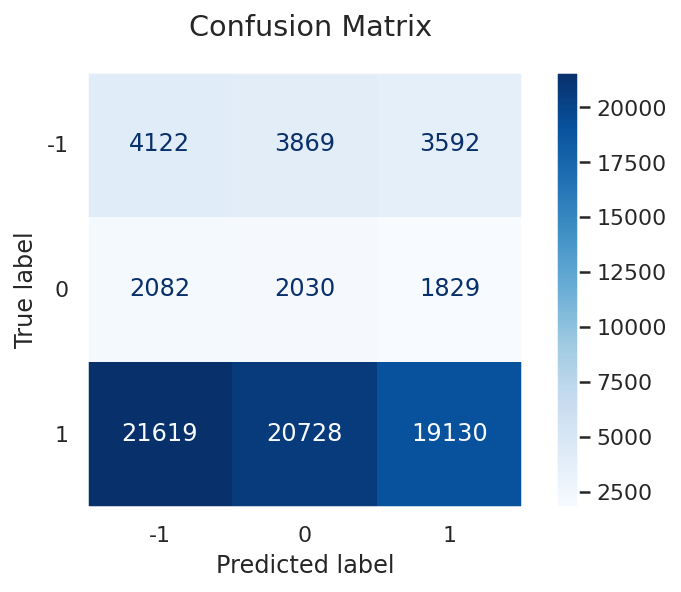

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_estimator(
    model, valid, y_valid, cmap=plt.cm.Blues
)
disp.figure_.suptitle("Confusion Matrix")
plt.grid(False)
plt.show()

# Using Word2vec and Cosine Similarities

## On 'Text' Reviews

In [ ]:
cln_df = train_df[["Text", "sentiment"]].copy()
cln_df.dropna(subset=["Text"], inplace=True)

<Figure size 432x288 with 0 Axes>

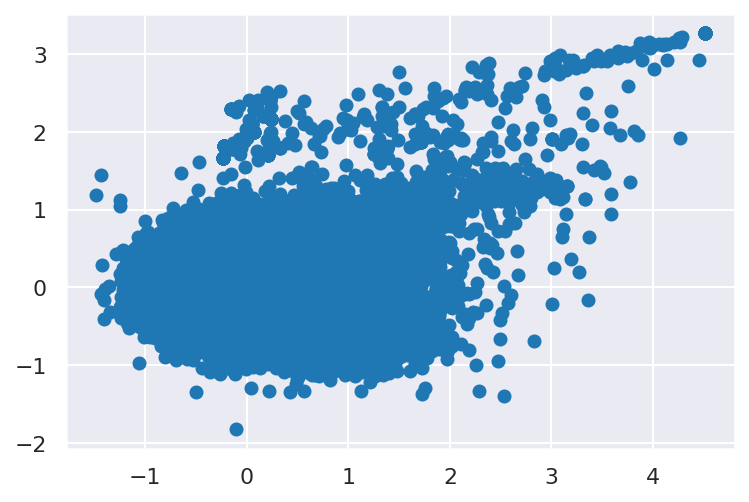

<Figure size 432x288 with 0 Axes>

In [ ]:
pca = decomposition.PCA(n_components = 2)
xy_2d = pca.fit_transform(np.stack(cln_df.embeddings))
x_2d, y_2d = xy_2d.T
plt.scatter(x_2d, y_2d)
plt.figure()

In [ ]:
df2d = pd.DataFrame(xy_2d, columns = ['x', 'y'])
df2d['label'] = list(cln_df['sentiment'])
df2d

,x,y,label
0,0.156001,-0.072150,-1
1,0.149652,-0.585897,-1
2,-0.484247,0.468958,1
3,0.106357,-0.151614,1
4,-0.244181,0.694302,-1
...,...,...,...
314630,0.144161,-0.143942,1
314631,-0.214192,-0.177774,1
314632,0.184489,-0.300068,1
314633,0.419950,-0.085443,1


Text(0.5, 1.0, "PCA of 'Text' Reviews in 2 dimensions")

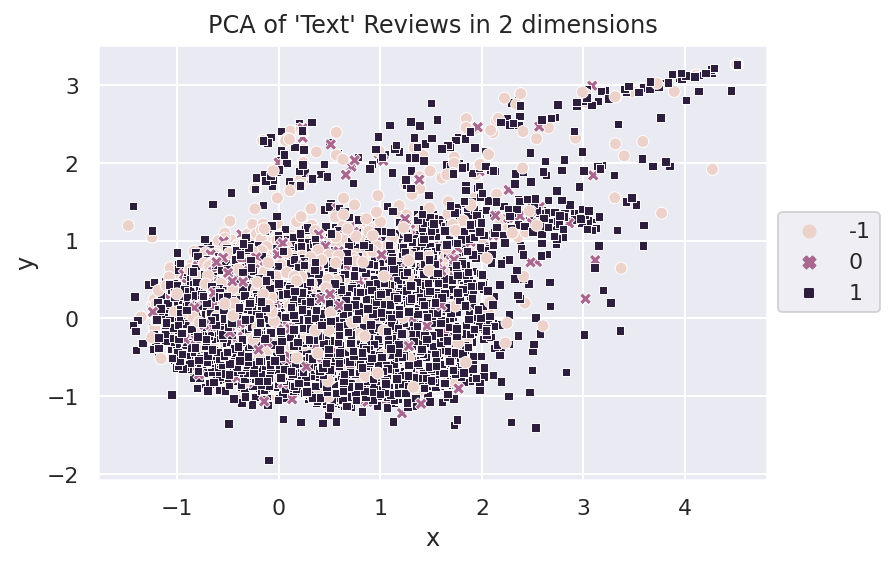

In [ ]:
g = sns.scatterplot(x="x", y="y", data=df2d, hue="label", style="label")
g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
g.set_title("PCA of 'Text' Reviews in 2 dimensions")

> In this part, we are interested to see if we can use cosine similarity to classify.

In [ ]:
texts_positive = cln_df[cln_df.sentiment == 1].head(5) # We get the head of the positive texts
texts_neutral = cln_df[cln_df.sentiment == 0].head(5)
texts_negative = cln_df[cln_df.sentiment == -1].head(5)
all_texts = pd.concat([texts_positive, texts_neutral, texts_negative]) # We merge them

vectorizer = CountVectorizer()
X = all_texts.Text
X_transformed = vectorizer.fit_transform(list(X)) # We convert our texts to an array of integers using count vectorizer
d = {text: X_transformed.toarray()[i] for i, text in enumerate(list(X))}
df_cs = pd.DataFrame.from_dict(d, orient="index", columns = vectorizer.get_feature_names_out())

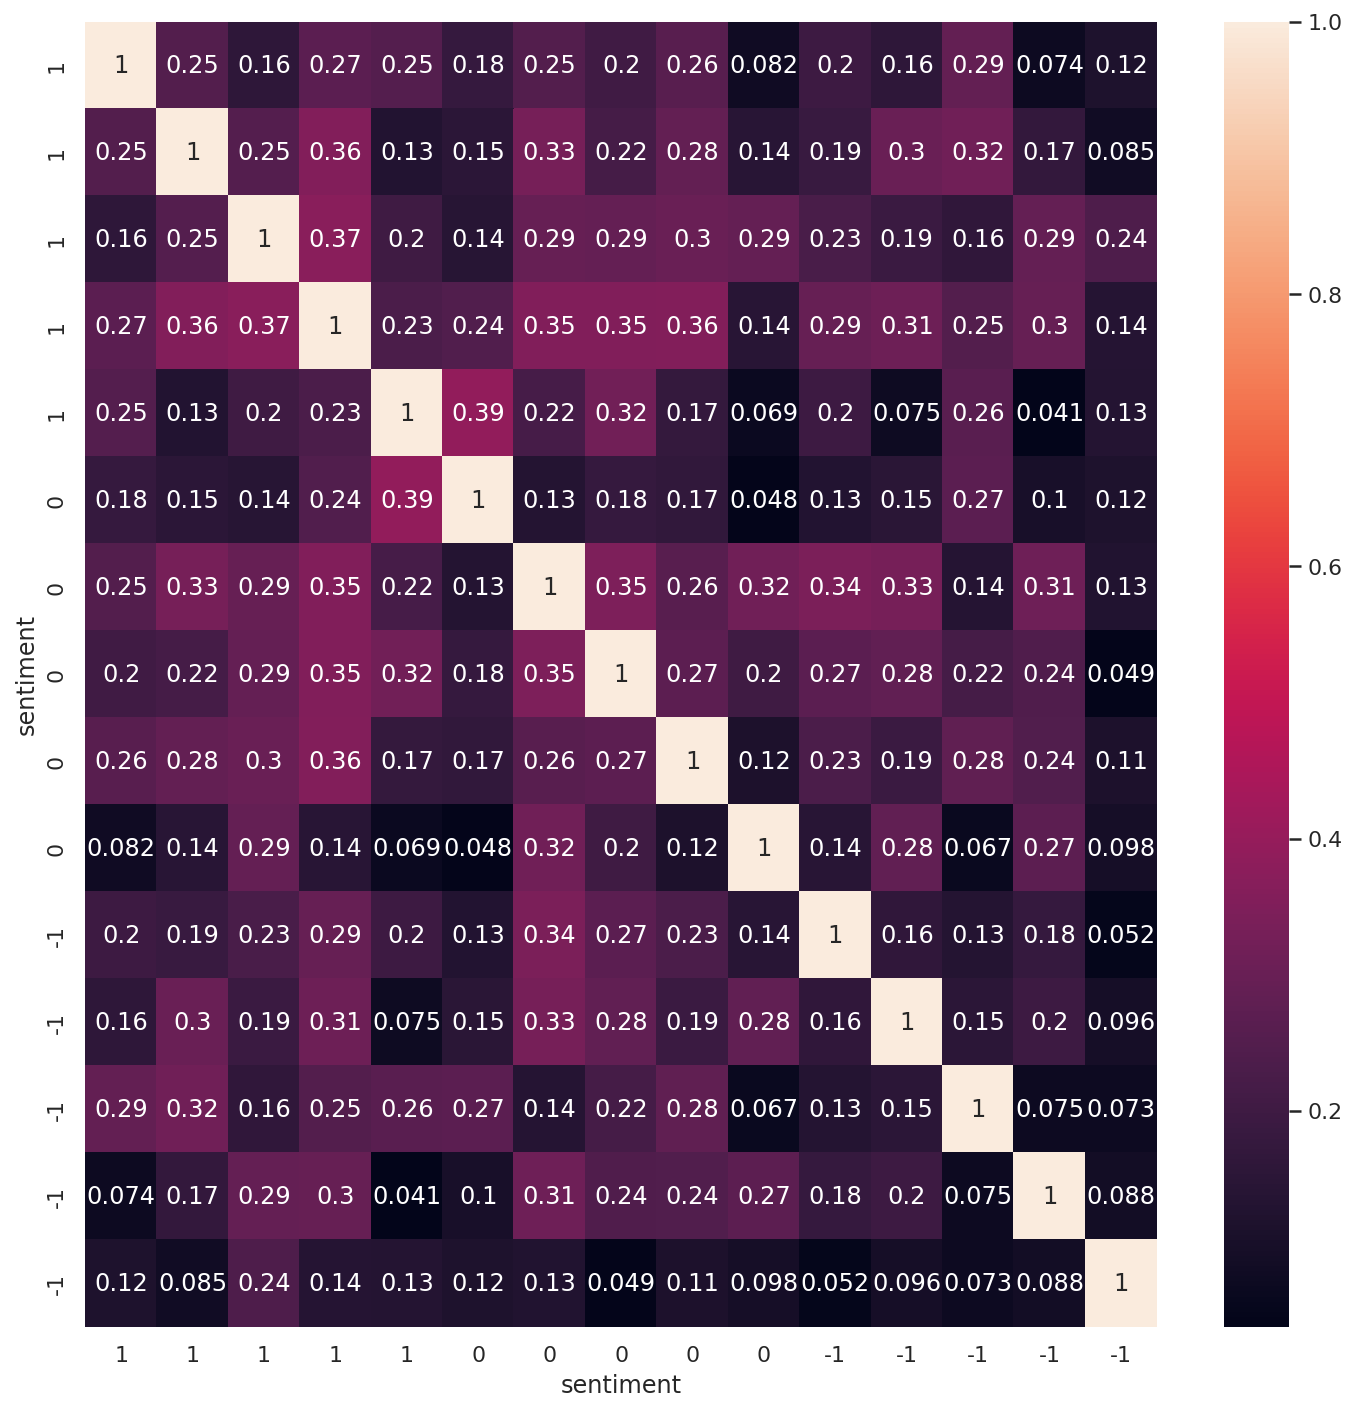

In [ ]:
cosine_similarity_matrix = cosine_similarity(df_cs) # We compute the cosine similarity between each texts
df_cosine = pd.DataFrame(cosine_similarity_matrix, index = all_texts.sentiment, columns = all_texts.sentiment)
plt.figure(figsize = (12, 12))
sns.heatmap(df_cosine, annot = True)

The best case scenario would be that the cosine similarity between instances of class 1 is pretty close to each other and the same for the 2 others classes. 

Nevertheless, we see that it is not the case.

We are going to try on summaries and with all the data.

## On 'Summary'

In [ ]:
cln_df = train_df[["Summary", "sentiment"]].copy()
cln_df.dropna(subset=["Summary"], inplace=True)

In [ ]:
# Like previously we use word embedding since summaries are generally 2-5 words
cln_df["words"] = cln_df.Summary.str.findall(tokenizer_re)
cln_df["embeddings"] = cln_df.words.progress_map(vectorize_sentence_bow)
cln_df.dropna(inplace=True)

  0%|          | 0/316002 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
import collections
c = collections.Counter()
for w in cln_df['words']:
    c.update([len(w)])
print('Average length is', sum(key * count for key, count in c.items()) / sum(count for count in c.values()))

Average length is  4.563723481385745


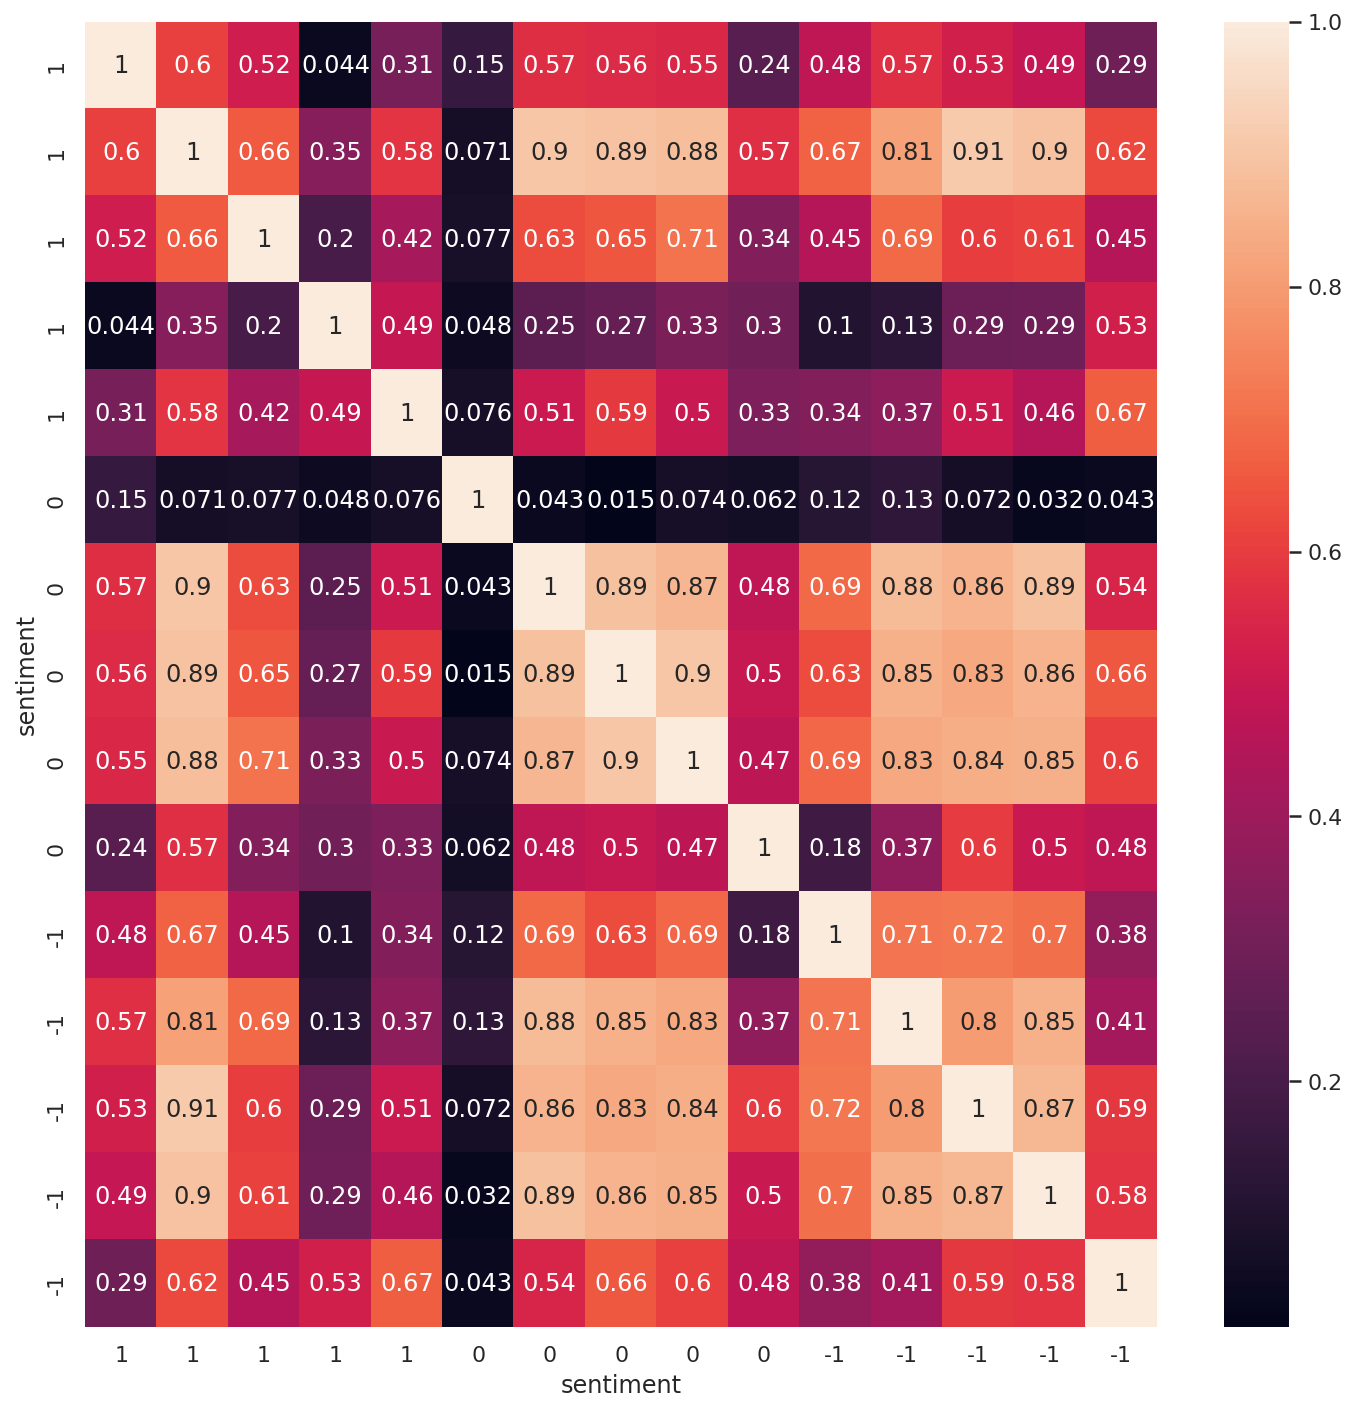

In [ ]:
texts_positive = cln_df[cln_df.sentiment == 1].head(5) # We get the head of the positive texts
texts_neutral = cln_df[cln_df.sentiment == 0].head(5)
texts_negative = cln_df[cln_df.sentiment == -1].head(5)
all_texts = pd.concat([texts_positive, texts_neutral, texts_negative]) # We merge them

d = {all_texts.iloc[i].Summary: emb for i, emb in enumerate(list(all_texts.embeddings))} # This time we use embeddings
df_cs = pd.DataFrame.from_dict(d, orient="index")
cosine_similarity_matrix = cosine_similarity(df_cs) # We calculate the cosine similarity between all the texts
df_cosine = pd.DataFrame(cosine_similarity_matrix, index = all_texts.sentiment, columns = all_texts.sentiment)
plt.figure(figsize = (12, 12))
sns.heatmap(df_cosine, annot = True)

It seems complicated to distinguish some summaries between them as we can have a high cosine similiarity for two different summaries of different feelings. It is the same problem for both word embedding and CountVectorizer.

## Using Cosine Similarity


However, we can try to use the cosine metric in a KNN.

In [ ]:
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(
    np.stack(cln_df.embeddings),
    cln_df.sentiment,
    test_size=0.2,
    random_state=1
)

In [ ]:
model = neighbors.KNeighborsClassifier(n_neighbors = 200, metric = 'cosine', weights = "distance") # We can use the cosine similarity instead of the euclidean distance
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.25      0.36      6705
           0       0.44      0.10      0.17      3727
           1       0.81      0.97      0.88     33981

    accuracy                           0.79     44413
   macro avg       0.63      0.44      0.47     44413
weighted avg       0.75      0.79      0.74     44413



What we hoped is that if we forced the model to have a higher number of neightbors in order to classify, and that we weight their impact (with the parameters *weights*  in the classification) we will have better result.

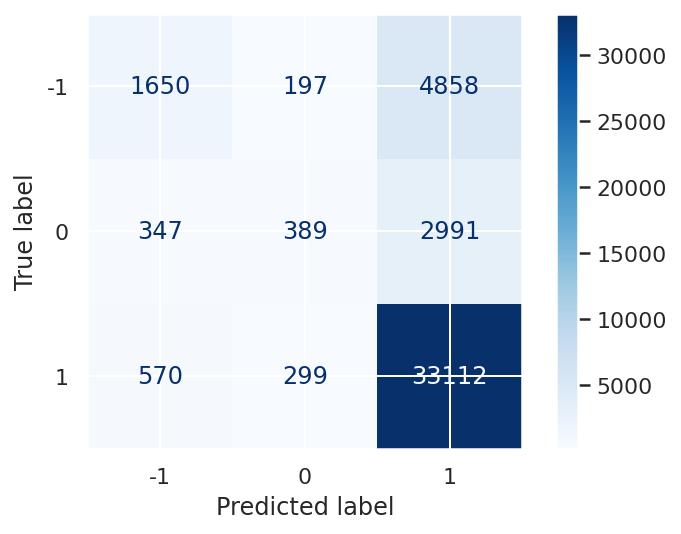

In [ ]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred, cmap=plt.cm.Blues
)

We do not get really good results, but it was interesting to try.
Many class 0 and -1 were classified as 1. We think it is because there are too much instances of class 1 (and the weighting is maybe not enough) hence many classification as class 1. We will do the same but with less neighbors.

              precision    recall  f1-score   support

          -1       0.62      0.31      0.41      6705
           0       0.44      0.12      0.19      3727
           1       0.82      0.97      0.89     33981

    accuracy                           0.80     44413
   macro avg       0.63      0.47      0.50     44413
weighted avg       0.76      0.80      0.76     44413



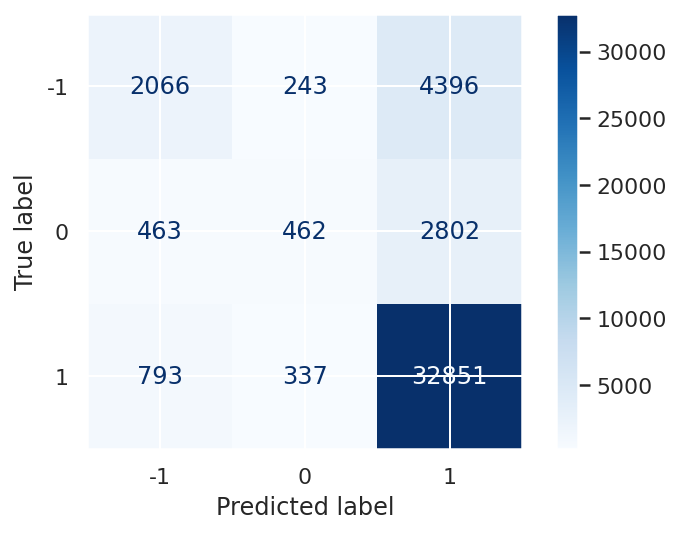

In [ ]:
model = neighbors.KNeighborsClassifier(n_neighbors = 50, metric = 'cosine', weights = "distance") # We can use the cosine similarity instead of the euclidean distance
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred, cmap=plt.cm.Blues
)

We will undersample the train set.

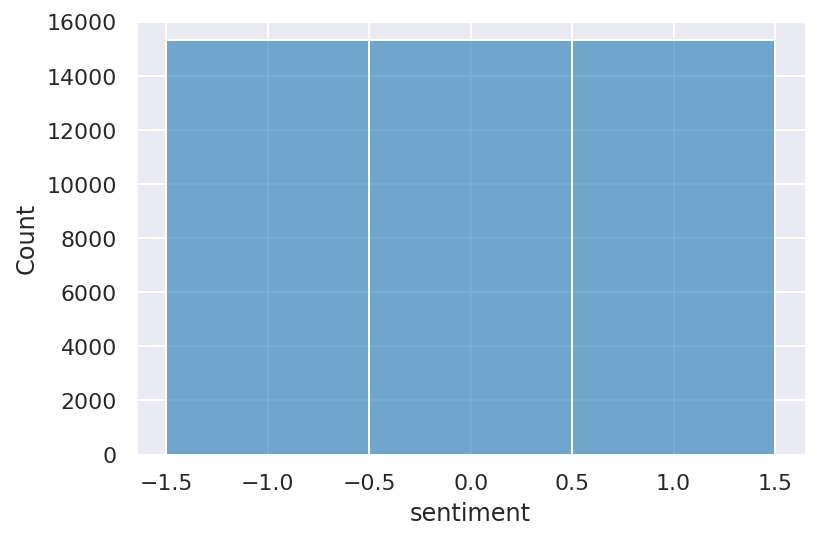

              precision    recall  f1-score   support

          -1       0.36      0.50      0.42      6705
           0       0.18      0.54      0.27      3727
           1       0.91      0.64      0.75     33981

    accuracy                           0.61     44413
   macro avg       0.48      0.56      0.48     44413
weighted avg       0.77      0.61      0.66     44413



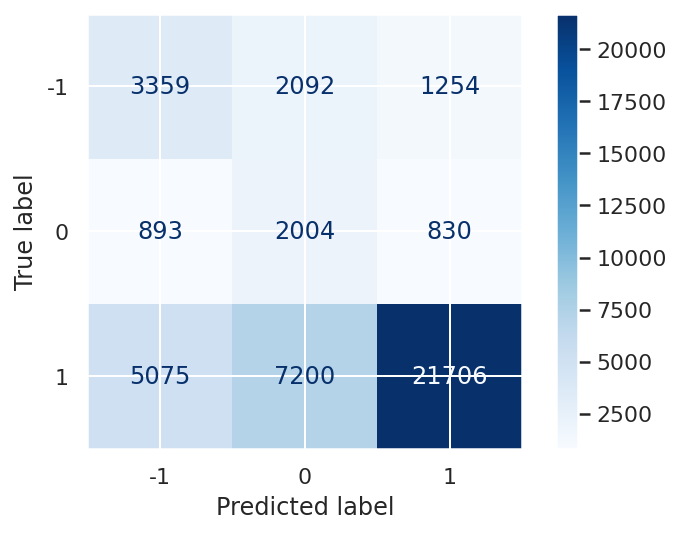

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

x_train, y_train = RandomUnderSampler().fit_resample(x_train,y_train)

sns.histplot(y_train, alpha=0.6, discrete=True)
plt.show()

model = neighbors.KNeighborsClassifier(n_neighbors=50,metric = 'cosine',weights="distance") # We can use the cosine similarity instead of the euclidean distance
model.fit(x_train, y_train)
y_pred = model.predict(x_valid)
print(metrics.classification_report(y_valid,y_pred))

disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_valid, y_pred, cmap=plt.cm.Blues
)

> As we can see in this matrix and the classification report:
* lower accuracy, which is a little bit expected as it was much easier to have a better accuracy by classifying almost everything as 1
* better macro (F1) average than in first case but lower than the second case
 * however, computing standard deviation gives a good insight:


| Case n°            | 1    | 2    | 3    |
|--------------------|------|------|------|
| Standard Deviation | 0.30 | 0.29 | 0.20 |

If we want to minimize the standard deviation between every F1, it would be interesting to use under sampling. It is the case if we do not want to put any priority in a class.

If we want to keep a good accuracy, keeping the previous approach (no under sampling) looks like the way to go.